<h1>Handwriting Letter GAN</h1>

<h3>Links</h3>
<ul>
    <li><a href=https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/>cGAN Code</a></li>
    <li><a href=https://keras.io/getting-started/functional-api-guide/>Keras Functional API</a></li>
</ul>

In [167]:
!pip install emnist

import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from emnist import *
from skimage import data, io, transform
import matplotlib.pyplot as plt

tf.test.gpu_device_name()

'/device:GPU:0'

In [168]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

(112800, 28, 28) (112800,)
(48000, 28, 28) (48000,)
0


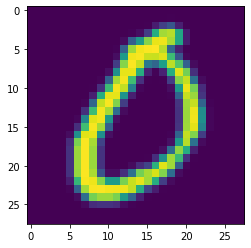

In [169]:
images, labels = extract_training_samples('balanced')
print(images.shape, labels.shape)
ind = []
for i in range(20):
  ind.extend(np.where(labels==i)[0])
images, labels = images[ind], labels[ind]
print(images.shape, labels.shape)
plt.imshow(images[0])
print(labels[0])

In [0]:
def define_discriminator(input_shape=(28, 28, 1), n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(input_shape[0] * input_shape[1])(emb)
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs
    merge = Concatenate()([image_in, re_label_h])
    # convnet
    h1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net
    fl = Flatten()(r2) 
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='sigmoid')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

In [0]:
def define_generator(latent_dim, n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)
    re_label_h = Reshape((7, 7, 1))(label_h)
    # noisy image input
    noise_in = Input(shape=(latent_dim,))
    noise_h = Dense(128*7*7)(noise_in)
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [0]:
def define_gan(gen, dis):
    # discriminator shouldn't be trainable
    dis.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    # feed to discriminator
    gan_output = dis([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
def prepare_inputs(images, labels):
    if len(images.shape) > 2:
      images = np.squeeze(images)
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)
    X, labels = images[rand_index], labels[rand_index]
    y = np.ones((n_samples, 1)) * 0.9 # discriminator target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=47):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)
    images = gen.predict([zin, lin])
    y = np.zeros((n_samples, 1))  # discriminator target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [images, lin], y

In [0]:
def train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # enumerate epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # train discriminator on real images
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            d_loss1, _ = dis.train_on_batch([X_real, labels_real], y_real)
            # train discriminator on generated images
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            #d_loss2 = dis.evaluate([X_fake, labels_fake], y_fake)[0]
            #if d_loss2 > 0.5:
            d_loss2, _ = dis.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare generator input
            [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
            # invert labels for fake samples (prevent vanishing gradients)
            y_gan = np.ones((batch_size, 1))
            # label smoothing
            #ind = np.random.choice(list(range(len(y_gan))), size=int(len(y_gan) * 0.01), replace=False)
            #y_gan[ind] = 1-y_gan[ind]
            # update generator loss
            g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
            # output losses
            if j % 20 == 0:
              print('Epoch {}, batch {}/{}:\tDiscriminator: real loss {}, fake loss {}\tGenerator: loss {}'
                  .format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # save the models
    gen.save('generator.h5')
    dis.save('discriminator.h5')
    gan_model.save('gan.h5')    

In [175]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
dis = define_discriminator()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, dis)
print("\nDiscriminator\n")
dis.summary()
print("\nGenerator\n")
gen.summary()
print("\nGAN\n")
gan_model.summary()

(48000, 28, 28, 1) (48000,)

Discriminator

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 50)        2350        input_51[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 1, 784)       39984       embedding_25[0][0]               
__________________________________________________________________________________________________
input_52 (InputLayer)           [(None, 28, 28, 1)]  0                                            
_______________________________________________

In [176]:
train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=50, batch_size=128)

Epoch 1, batch 1/375:	Discriminator: real loss 0.18053293228149414, fake loss 0.25099804997444153	Generator: loss 0.691983699798584
Epoch 1, batch 21/375:	Discriminator: real loss 0.08717477321624756, fake loss 0.1990181803703308	Generator: loss 0.9059562683105469
Epoch 1, batch 41/375:	Discriminator: real loss 0.05411873012781143, fake loss 0.037019357085227966	Generator: loss 1.7028816938400269
Epoch 1, batch 61/375:	Discriminator: real loss 0.025140516459941864, fake loss 0.01552685908973217	Generator: loss 2.147956371307373
Epoch 1, batch 81/375:	Discriminator: real loss 0.013432551175355911, fake loss 0.0081277284771204	Generator: loss 2.5263867378234863
Epoch 1, batch 101/375:	Discriminator: real loss 0.014011261984705925, fake loss 0.00552661856636405	Generator: loss 2.6703925132751465
Epoch 1, batch 121/375:	Discriminator: real loss 0.007921189069747925, fake loss 0.00379851832985878	Generator: loss 2.88728666305542
Epoch 1, batch 141/375:	Discriminator: real loss 0.01506566815

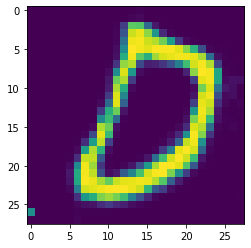

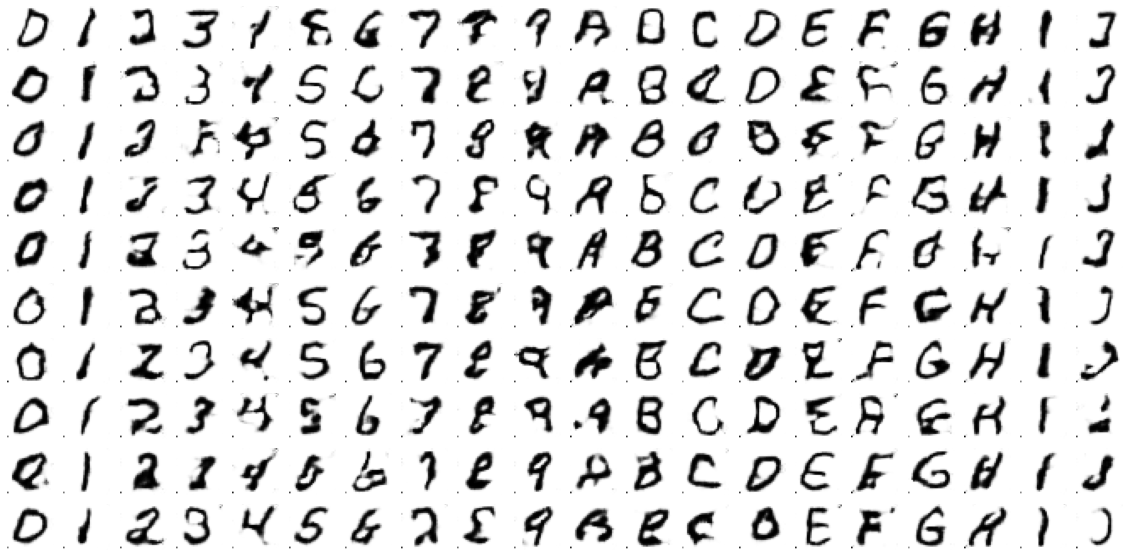

In [177]:
def show_generated(examples, n, c):
  fig = plt.figure(figsize=(c, n))
  for i in range(n*c):
    img = fig.add_subplot(n, c, i+1)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap='gray_r')
  plt.show()

n = 10
c = 20

model = load_model('generator.h5')
noise, _ = generate_latent_noise(latent_dim, n*classes)
labs = np.asarray([x for _ in range(n) for x in range(classes)])

X = model.predict([noise, labs])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
x = np.squeeze(X[0])
plt.imshow(x)

show_generated(X, n, c)